### Acknoledgments
Firstly I should acknoledge the various note books from which I have drawn inspiration for this code. 
- https://www.kaggle.com/jonas0/beginner-friendly-february-tabular-tutorial/
- https://www.kaggle.com/ttahara/tps-feb-2021-3gbdts-ensemble-baseline
- https://www.kaggle.com/tunguz/tps-feb-2021-with-lgbmregressor
- https://www.kaggle.com/tunguz/tps-02-21-feature-importance-with-xgboost-and-shap

## Do the imports 

In [11]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Load the data 
I have it download in my local directory, so you may need to adapt this. 

In [19]:
train = pd.read_csv('./tabular-playground-series-feb-2021/train.csv')
test  = pd.read_csv('./tabular-playground-series-feb-2021/test.csv')
smpl_sub = pd.read_csv("./tabular-playground-series-feb-2021/sample_submission.csv")

In [ ]:
train.head()

In [ ]:
test.head()

## Basic Date Examination 
See what we have in both train and test. Look for nan's or other things we note. 

In [ ]:
print(train.info())
print(train.isna().sum())

In [ ]:
print(test.isna().sum())

So it looks like we have a blend of the numerical features and catergorical features. So we will need to figure out a way to encode the catergorical ones. 
The good news is we don't have any missing values in either train or test and both train and test have the same features. 

In [8]:
# Split the 2 groups of data. 
cat_features = ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
numerical_features = ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5','cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']

## Explore the data with some plots 
We are trying t get a sense of how the data looks, are there any standout issues? For example outliers and features which have strange distributions or heavy weighting one way or the other.  
We can use the list of columns created above to do this. 

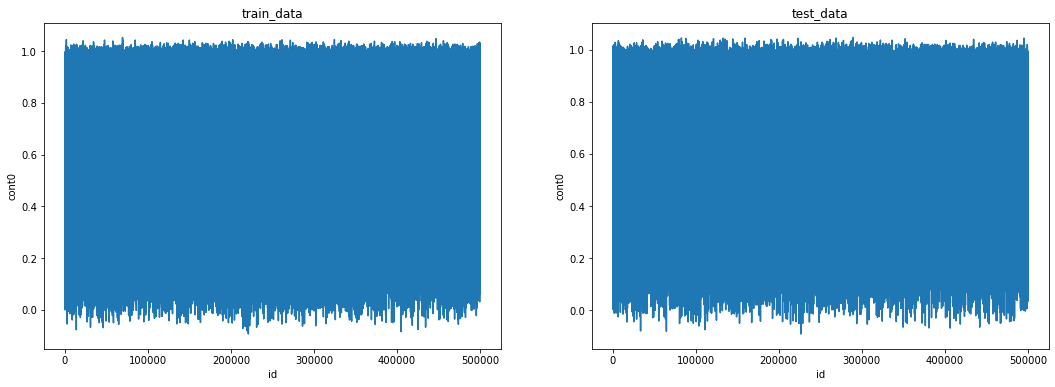

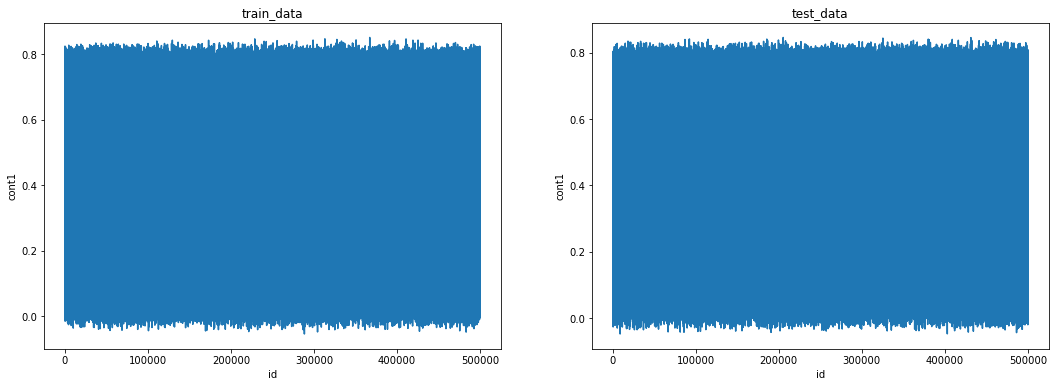

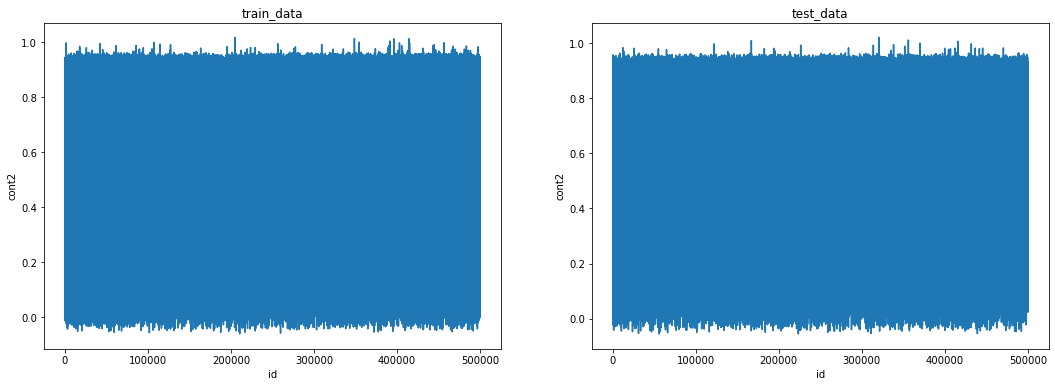

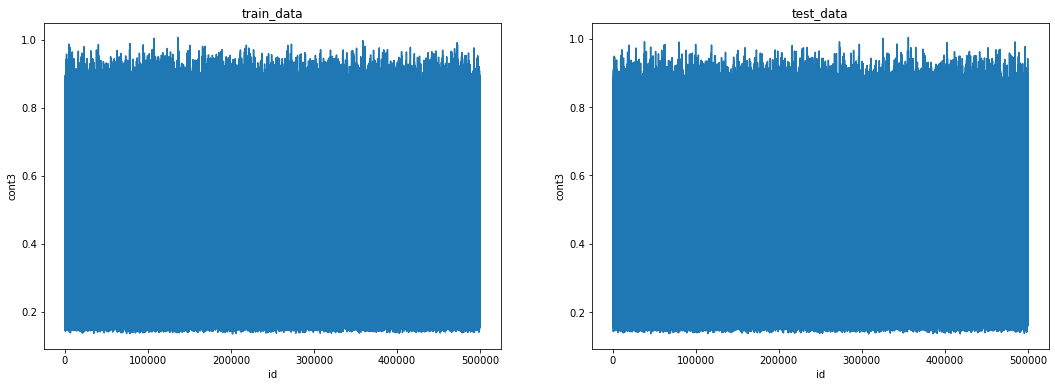

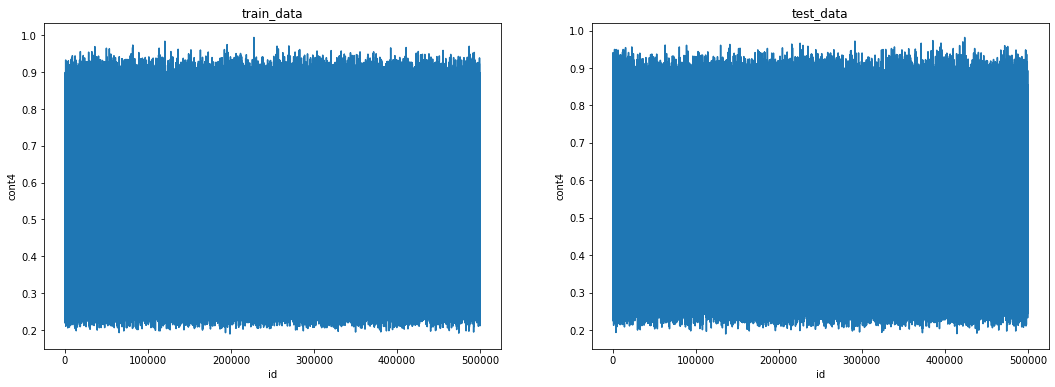

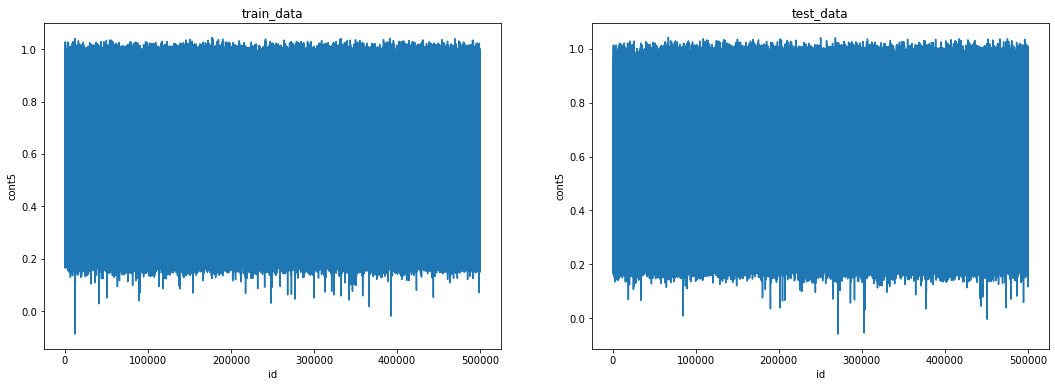

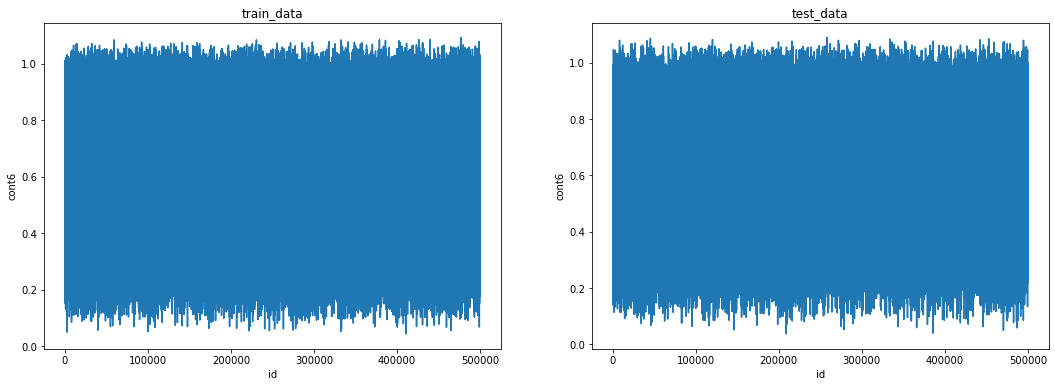

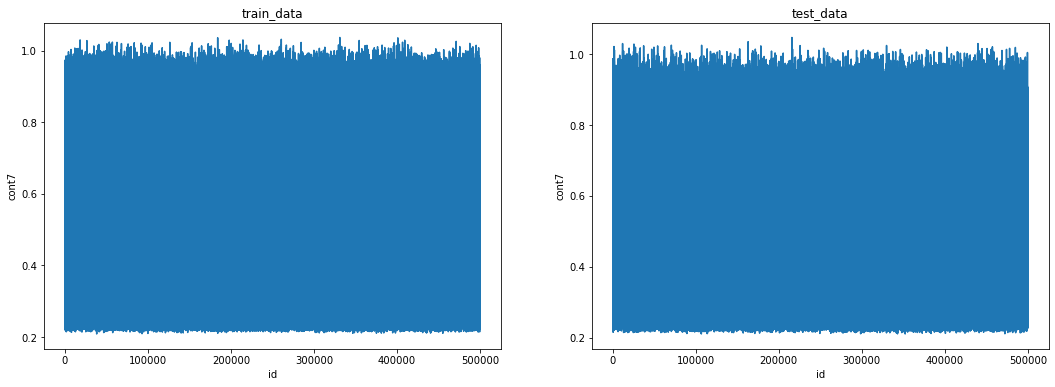

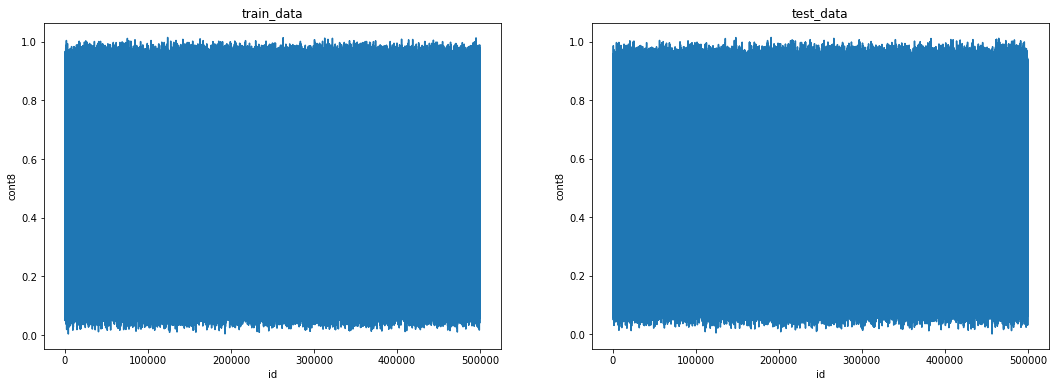

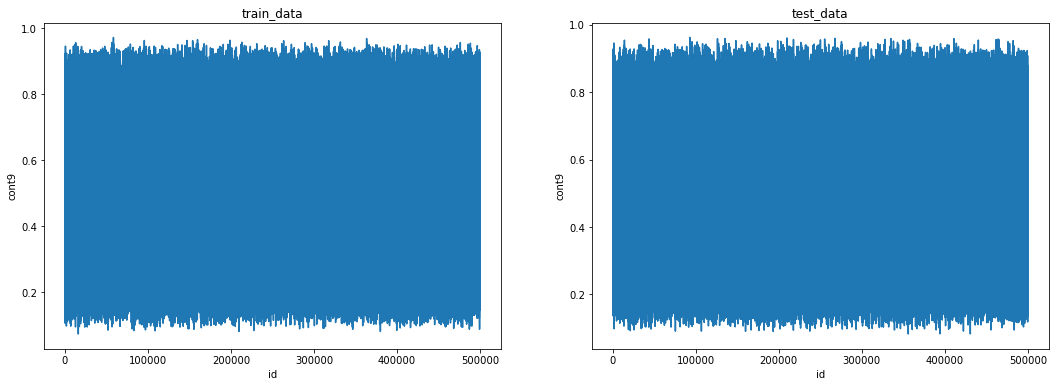

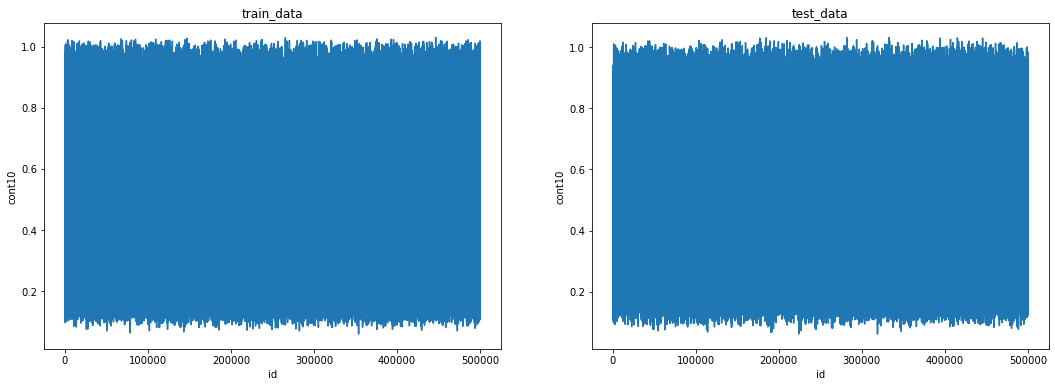

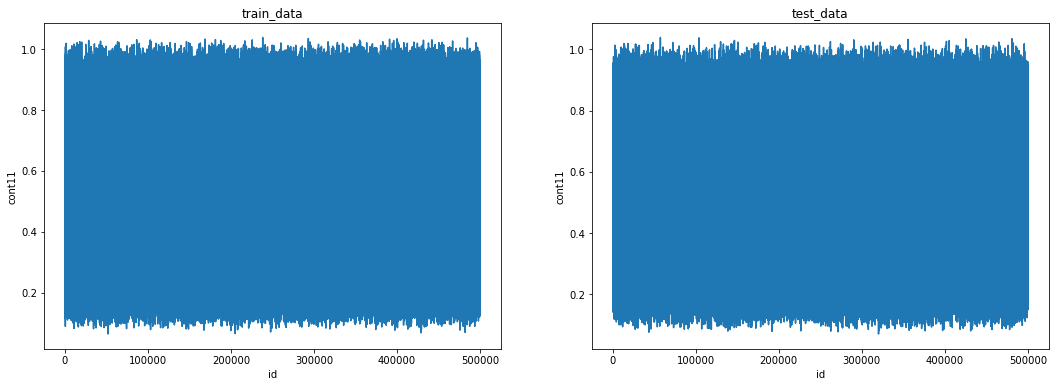

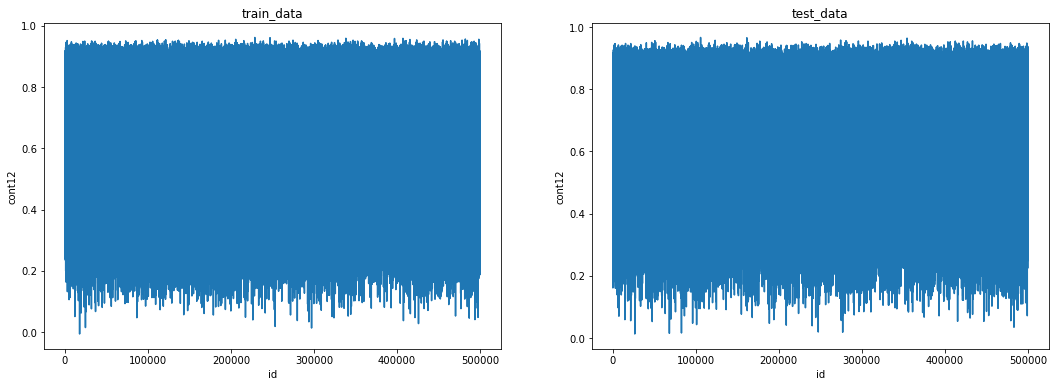

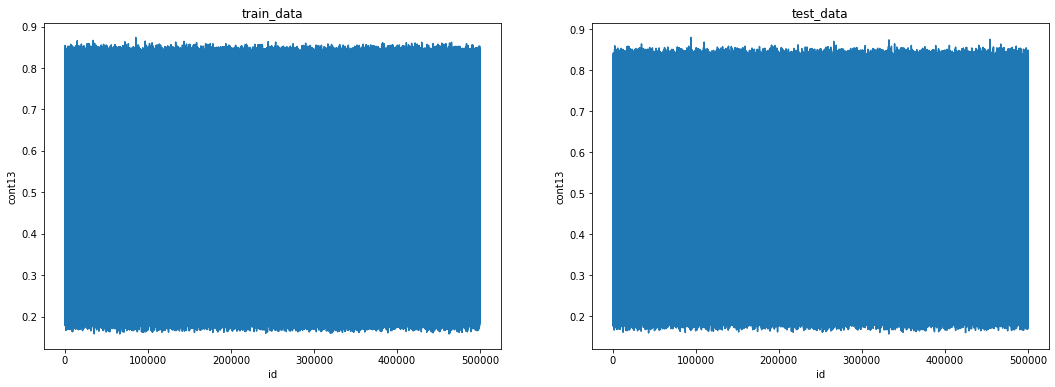

In [9]:
# Simple plots of the main features mainly to look for standout data weirdness 
for i in numerical_features:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    ax[0].plot(train["id"], train[i])
    ax[1].plot(test["id"], test[i])

    ax[0].set(xlabel="id", ylabel=i)
    ax[0].set_title('train_data')

    ax[1].set(xlabel="id", ylabel=i)
    ax[1].set_title("test_data")
    # I like to save the plots to look at in different porgrams the commented code below saves it
    #name ="./plots/" + i + "numplot.png"
    #plt.savefig(name)
    plt.show()

As these plots show the data is all very uniform without any crazy outliers. The only thing I picked up here are some negative values in the cont5 feature which is maybe worth investigating. 
Before that though some more plots. 

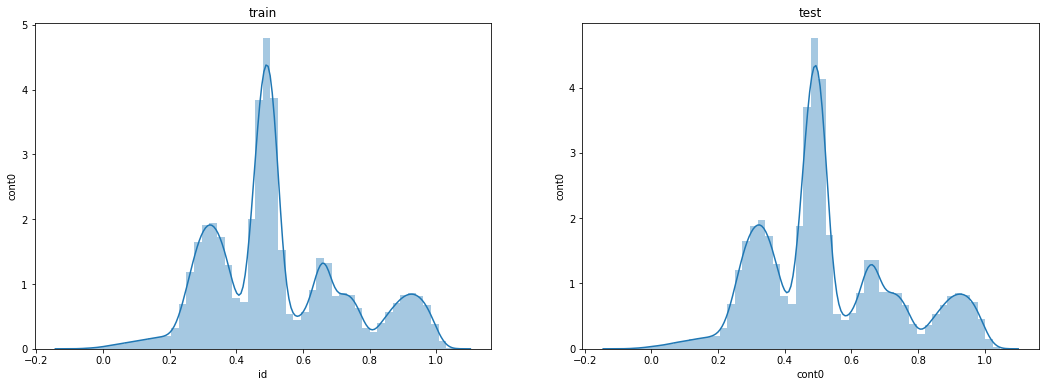

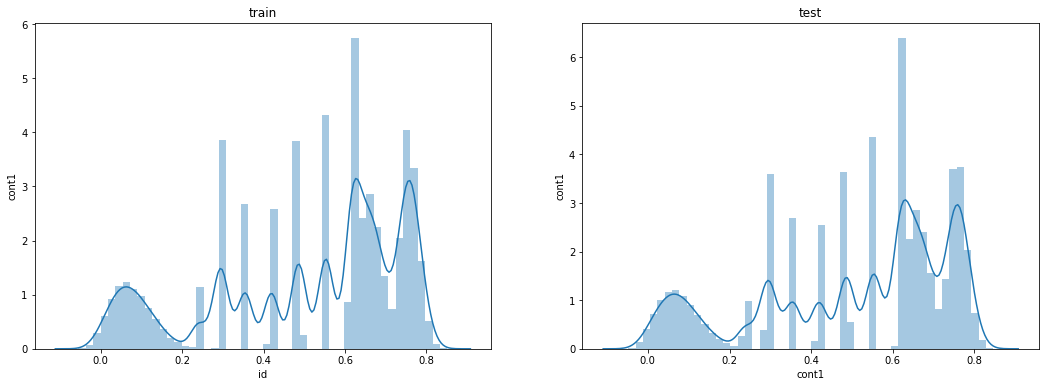

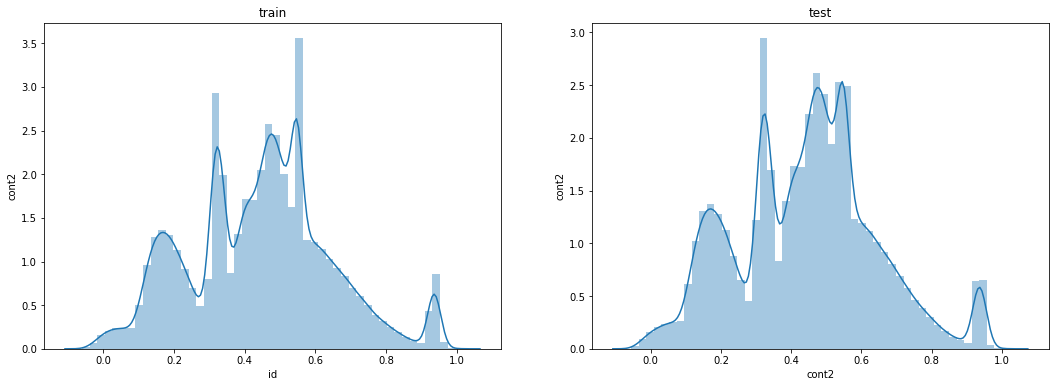

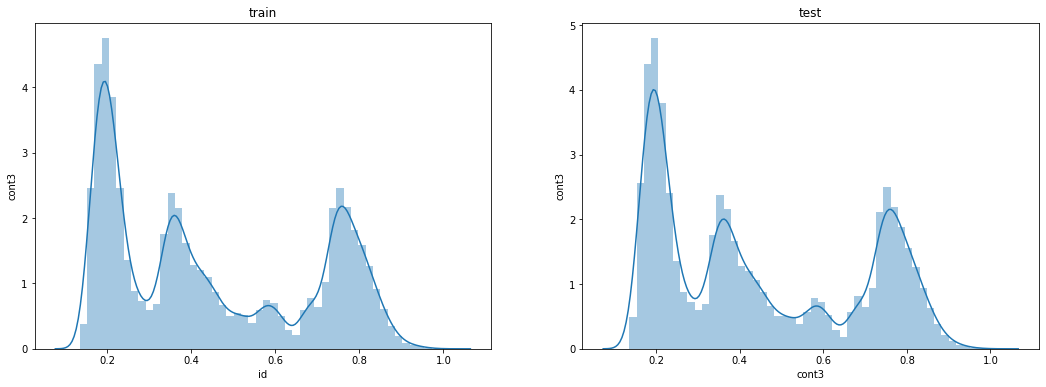

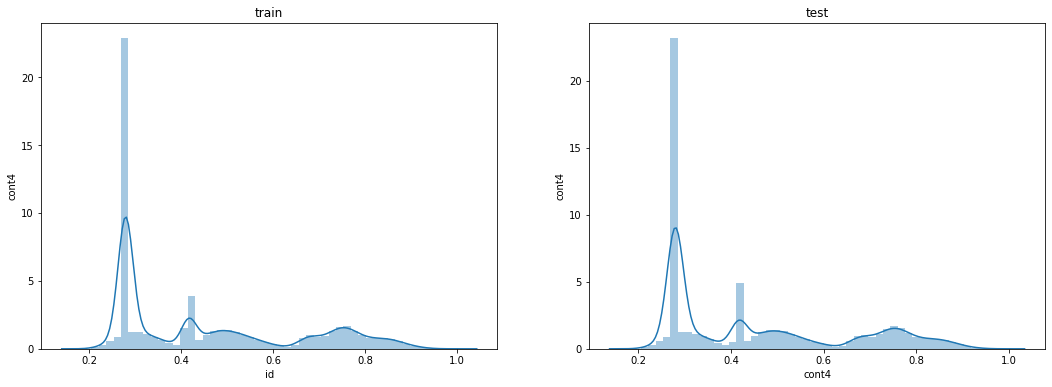

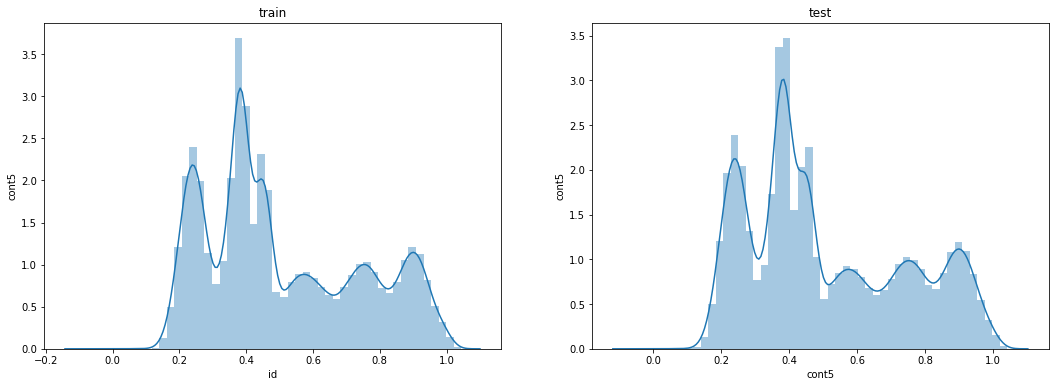

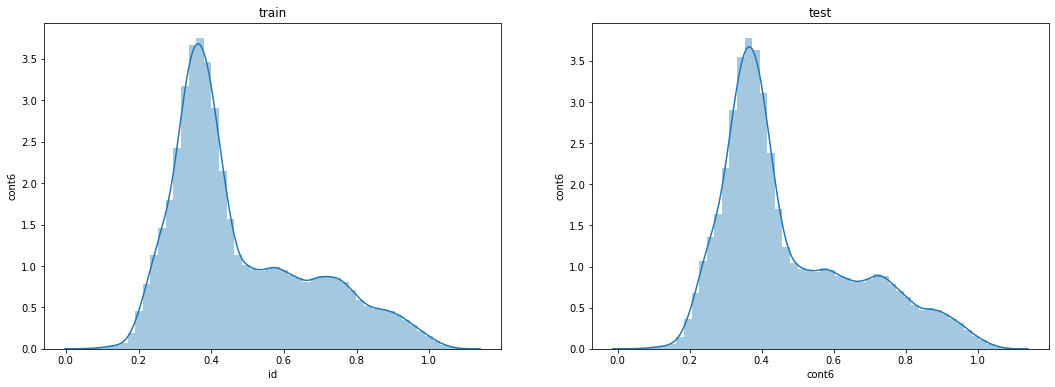

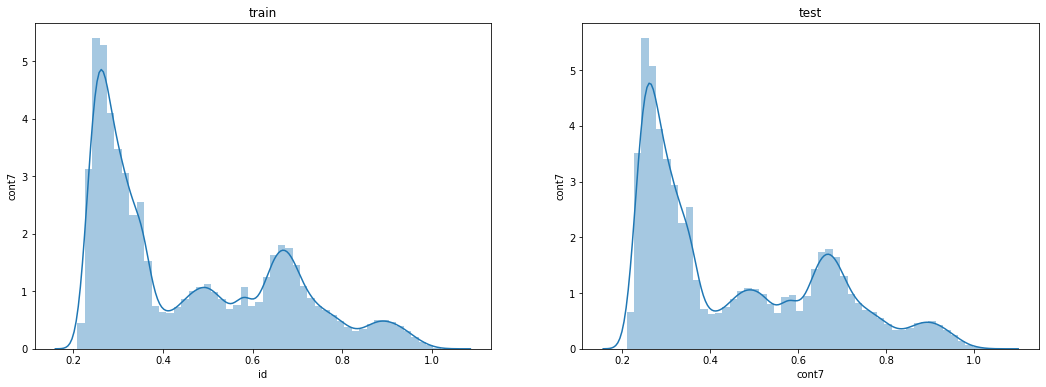

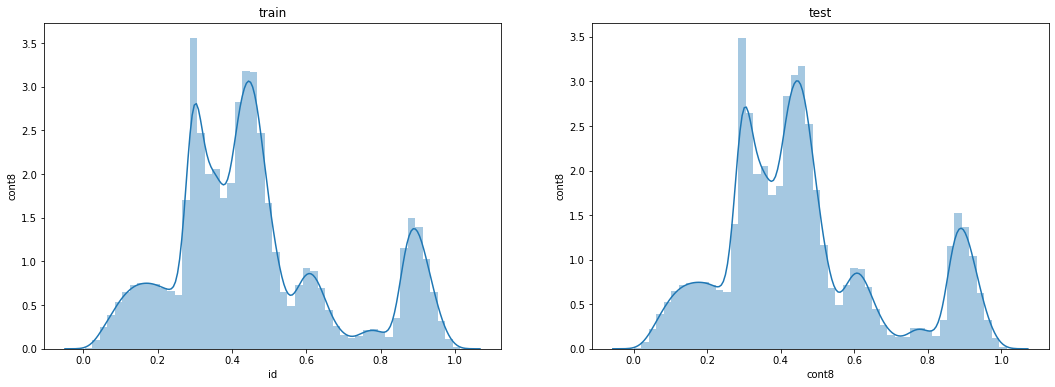

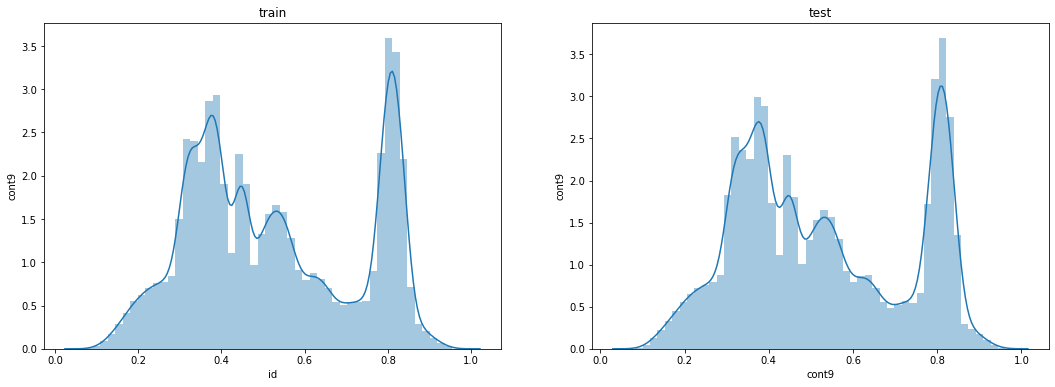

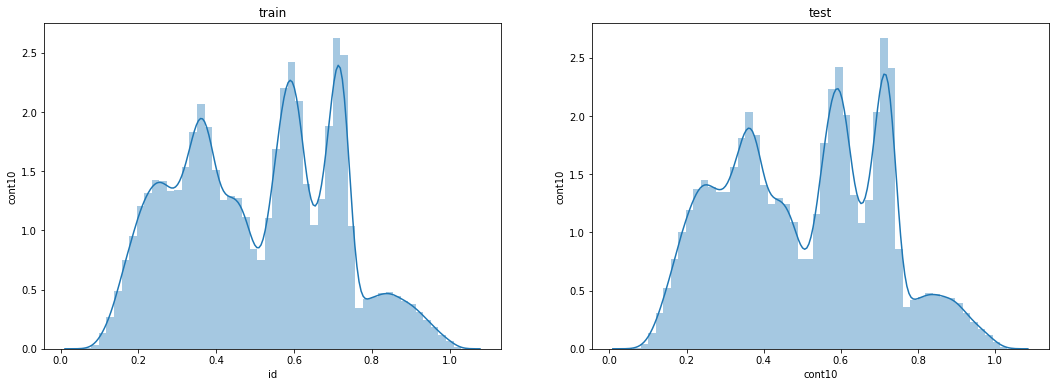

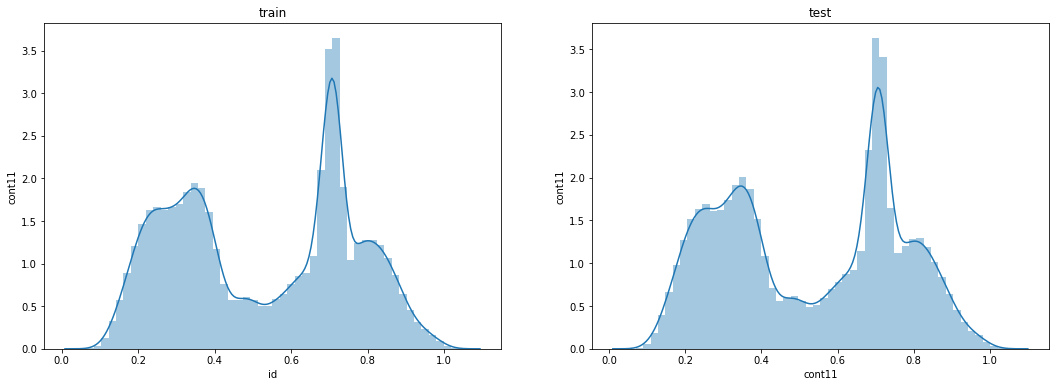

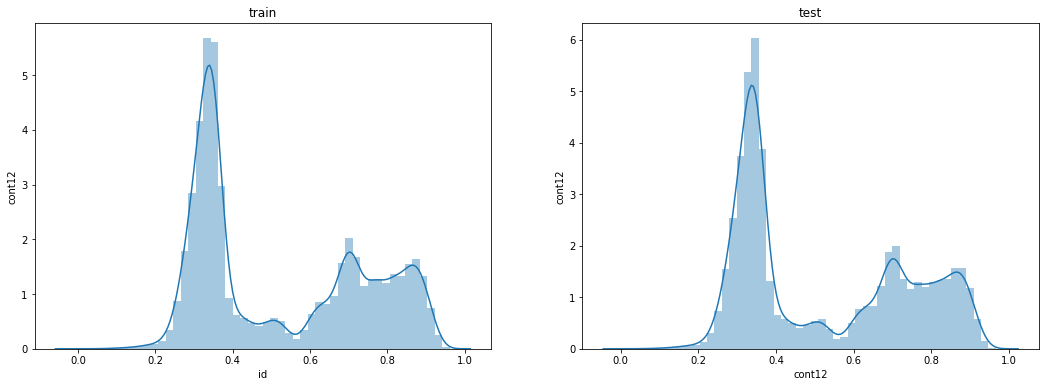

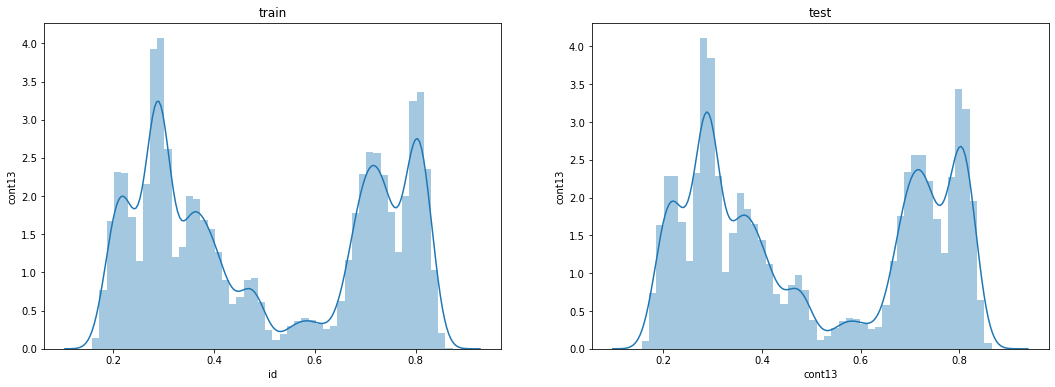

In [12]:
# Histograms of the numerical data. 
for i in numerical_features:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    sns.distplot(a=train[i], ax=ax[0])
    ax[0].set(xlabel='id', ylabel=i)
    ax[0].set_title('train')

    ax[1].set(xlabel='id', ylabel=i)
    ax[1].set_title("test")
    sns.distplot(a=test[i], ax=ax[1])
    #name ="./plots/" + i + "num_hist_plot.png"
    #plt.savefig(name)
    plt.show()

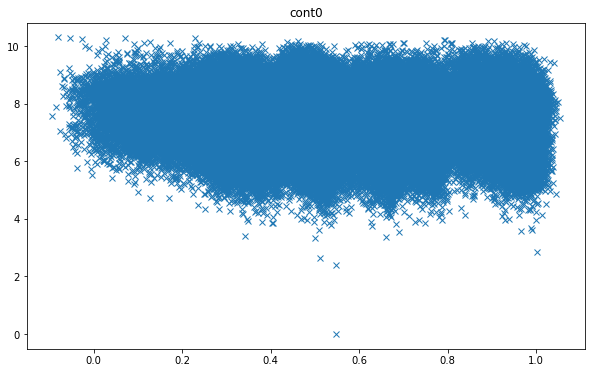

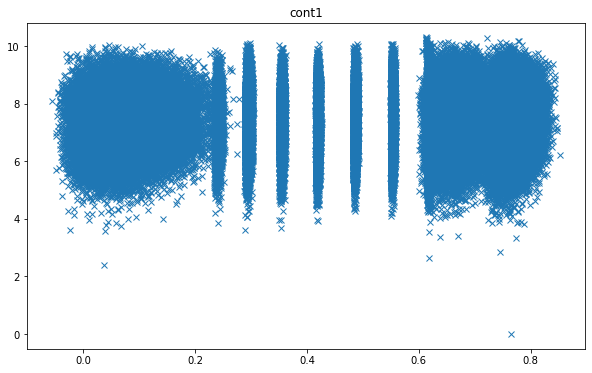

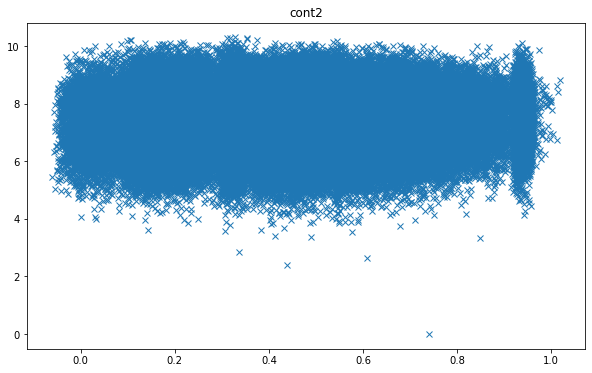

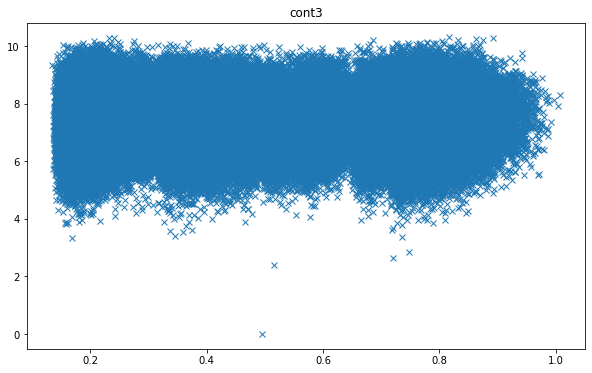

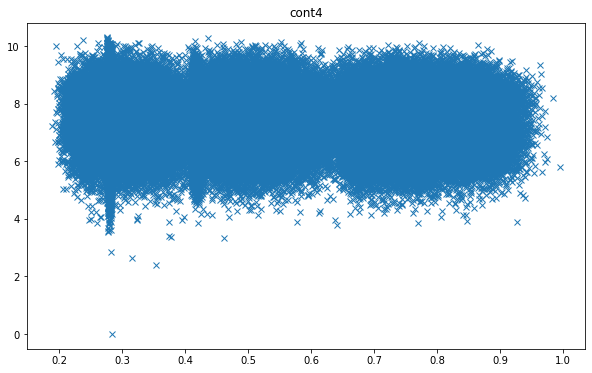

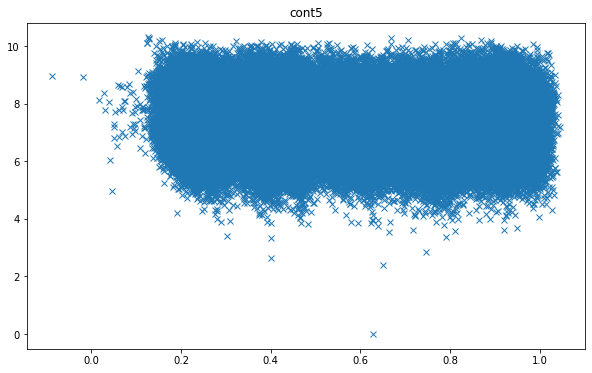

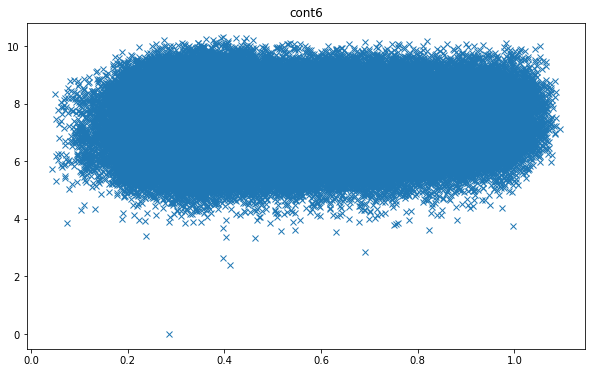

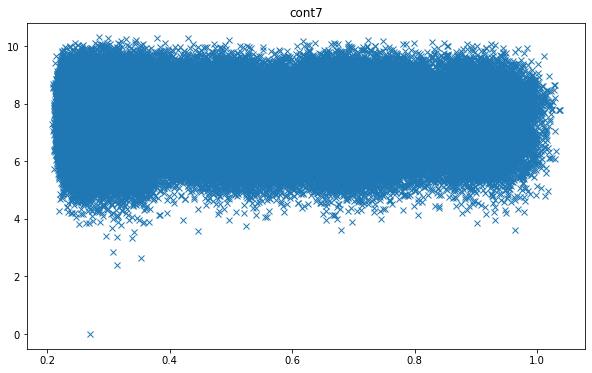

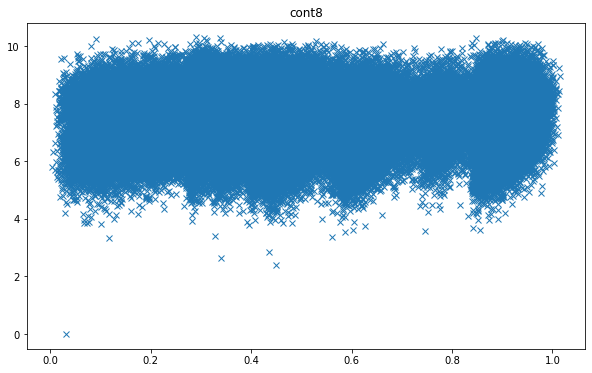

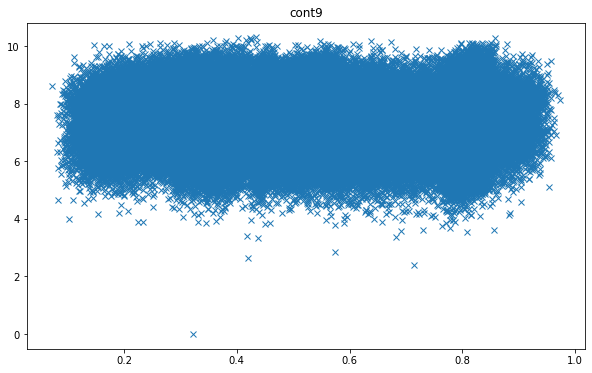

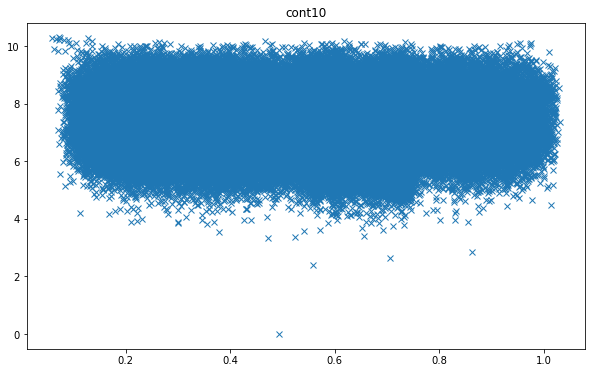

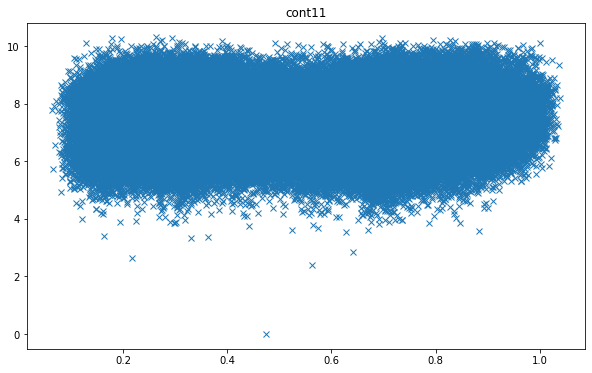

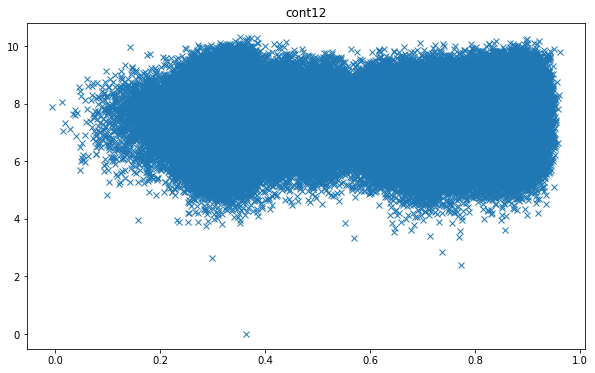

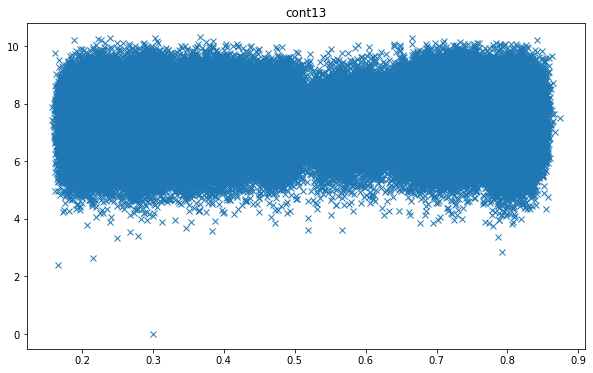

In [13]:
# Comparing the features to the traget 
for i in numerical_features:
    fig = plt.figure(figsize=(10, 6))
    plt.plot(train[i], train["target"], linestyle='', marker='x')
    plt.title(i)
    #name ="./plots/" +  i + "feature_vs_target_plot.png"
    #plt.savefig(name)
    plt.show()

In [ ]:
We do have an outlier which looks like an error, so we should proably just remove it. 

In [17]:
outlier = train.loc[train.target < 1.0]
print(outlier, "\n")
print(outlier.index)
# remove the outlier from the train_data set
train.drop([99682], inplace=True)

           id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont5  \
99682  166042    A    B    A    C    B    B    A    E    C  ...  0.627182   

          cont6    cont7     cont8     cont9    cont10    cont11    cont12  \
99682  0.286103  0.26953  0.031187  0.321662  0.493695  0.474234  0.363619   

         cont13  target  
99682  0.300035     0.0  

[1 rows x 26 columns] 

Int64Index([99682], dtype='int64')


### Now for plotting the catergorical data 

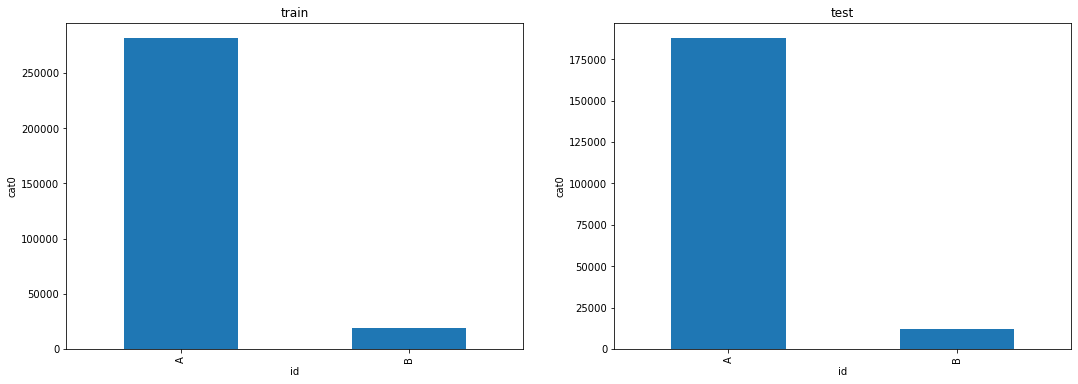

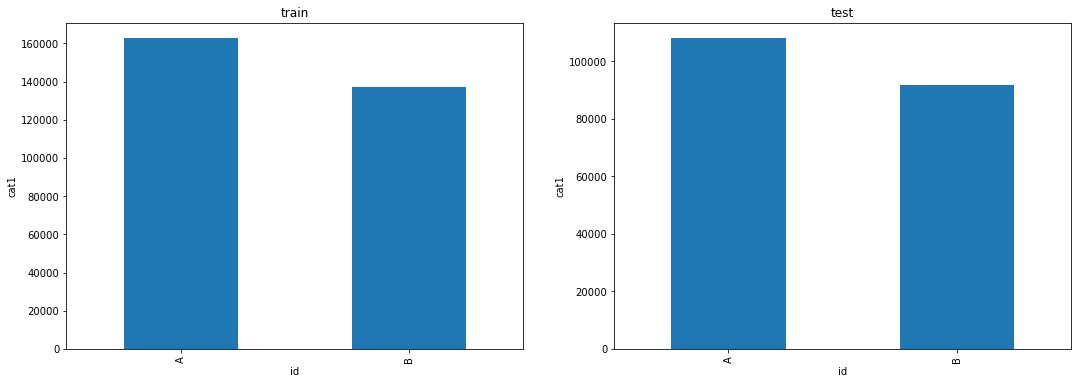

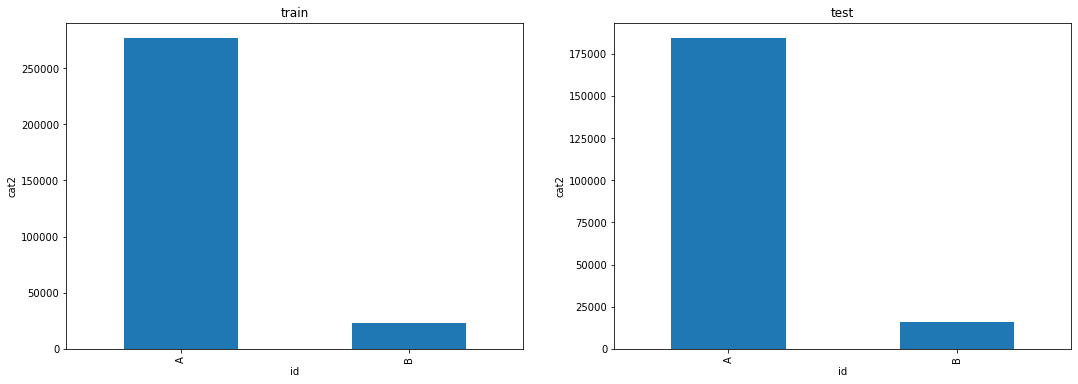

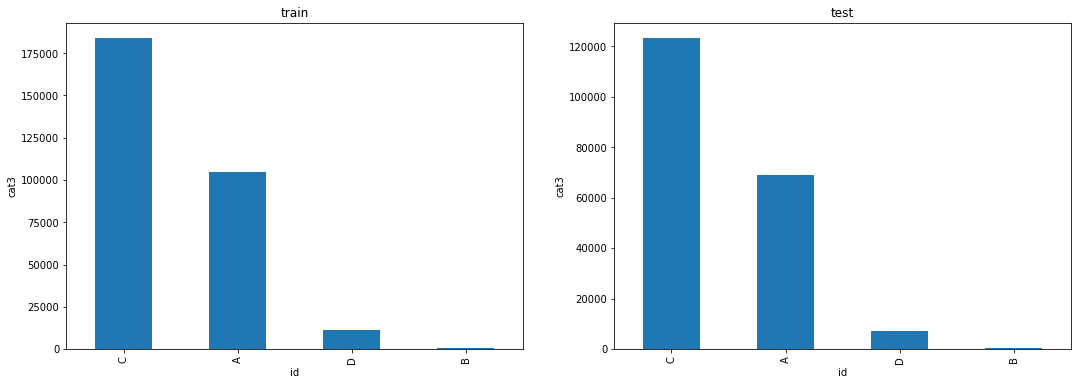

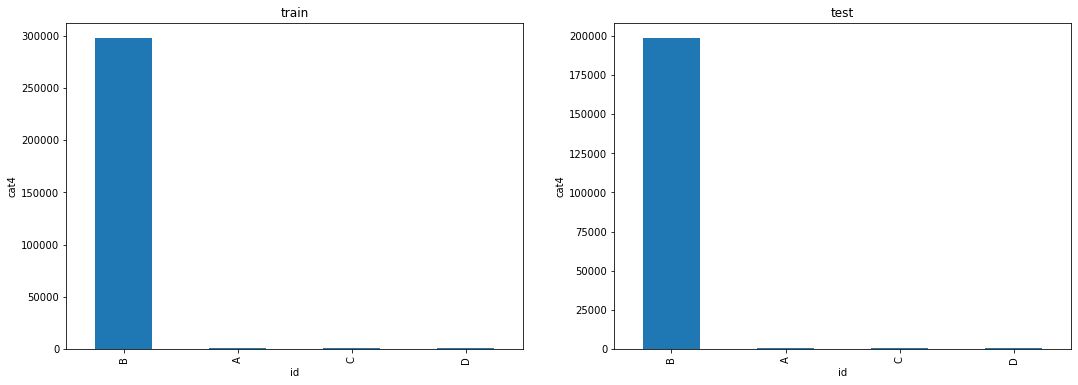

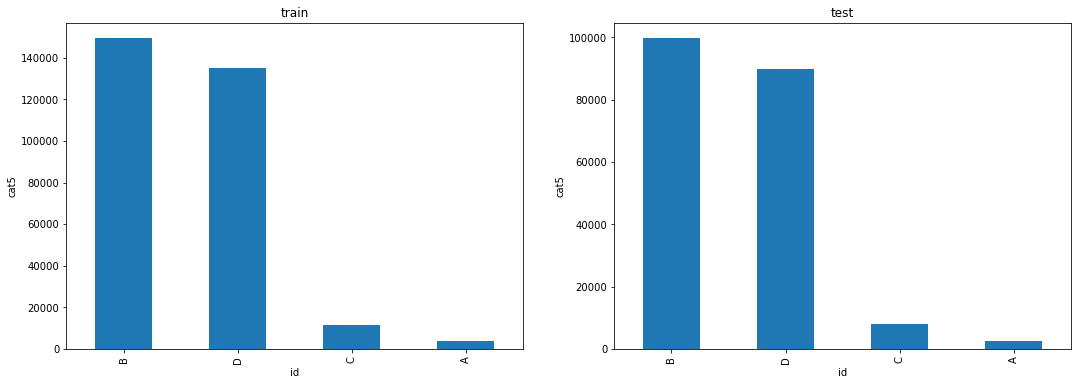

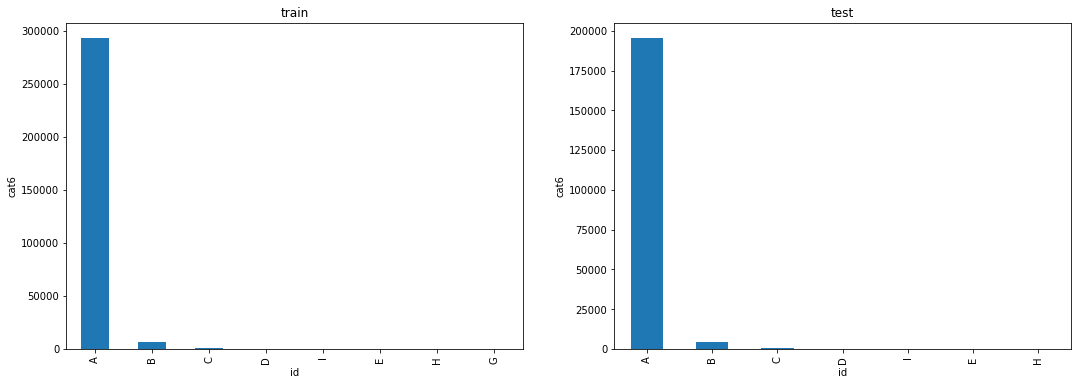

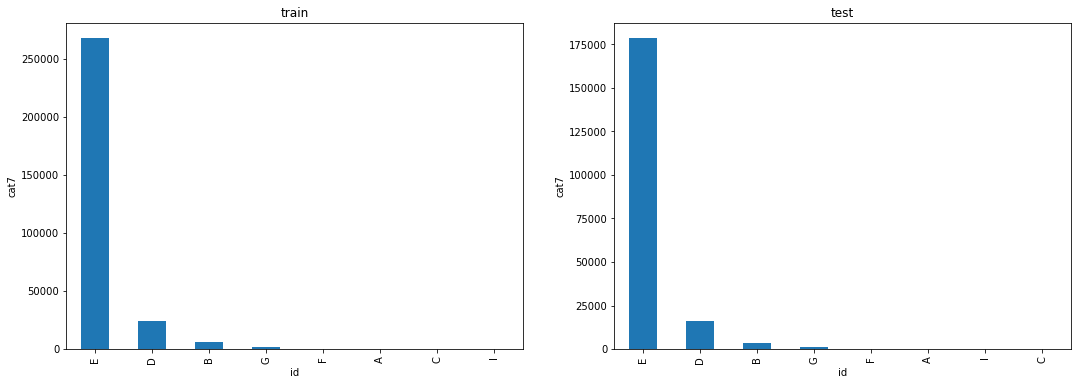

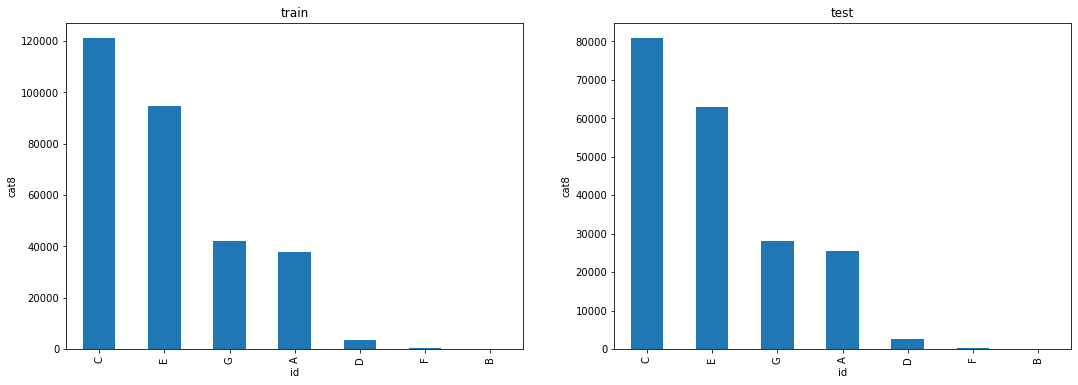

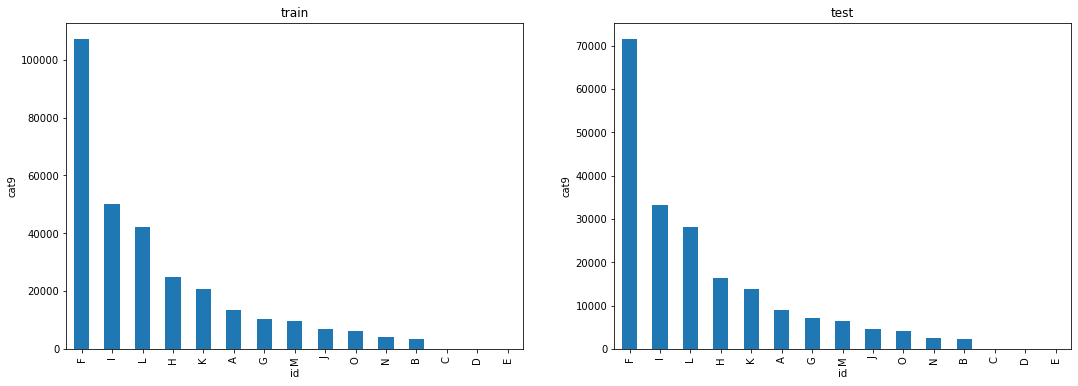

In [14]:
# bar plots of the categroies 
for i in cat_features:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    train[i].value_counts().plot(kind='bar', ax=ax[0])
    ax[0].set(xlabel='id', ylabel=i)
    ax[0].set_title('train')

    ax[1].set(xlabel='id', ylabel=i)
    ax[1].set_title("test")
    test[i].value_counts().plot(kind='bar', ax=ax[1])
    #name ="./plots/" + i + "cat_bar_plot.png"
    #plt.savefig(name)
    plt.show()

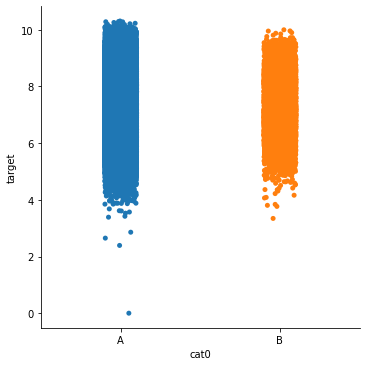

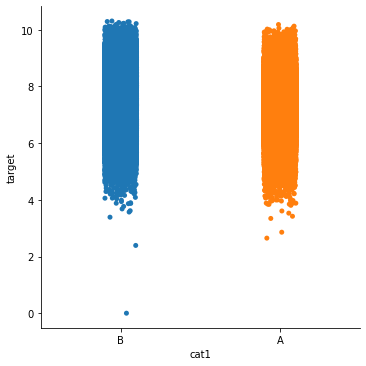

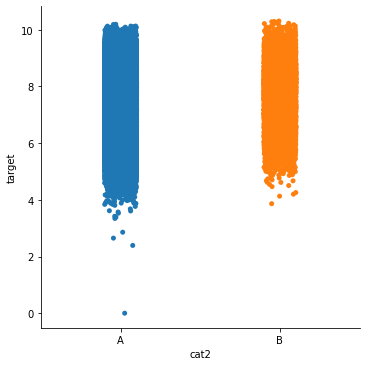

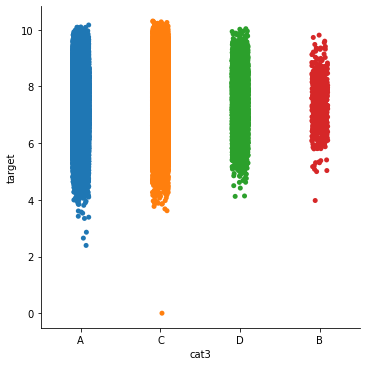

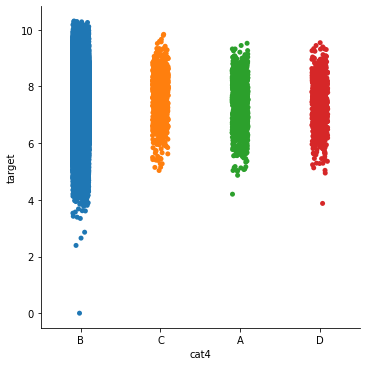

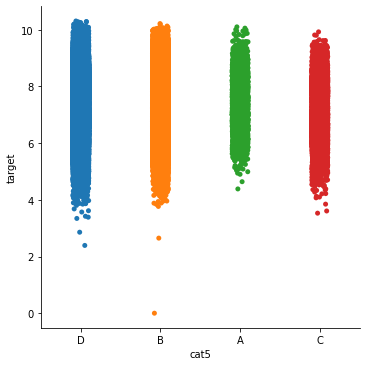

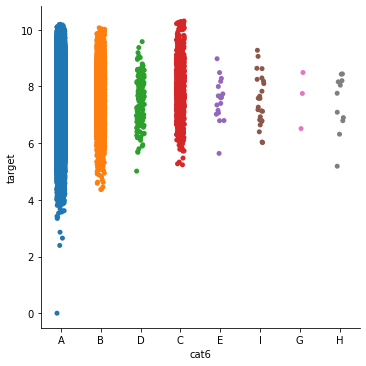

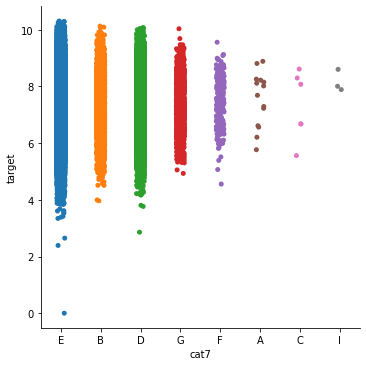

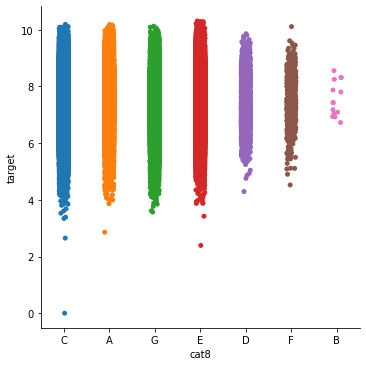

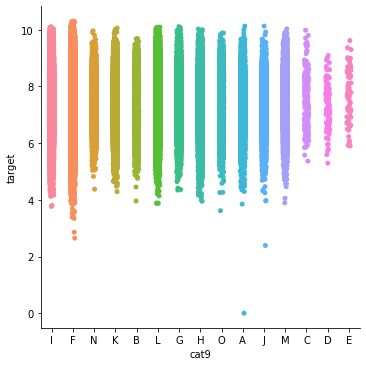

In [15]:
for i in cat_features:
    sns.catplot(x=i, y="target", data=train)
    #name ="./plots/" + i + "cat_plot.png"
    #plt.savefig(name)
    plt.show()

## Setting up to Train and Test Models
So now comes the leg work we have our data, and have removed an outlier, we should begin to train some models using kfold and then combine them for our submit. 

In [20]:
# Firstly we want to have a way of judging how long things are taking to run, the below method helps with this
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [21]:
# Now we are creating a class which holds the set up for the tree models we are using. 
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = None,
              cat_cols: list = None,
            ):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(
                X_train, label=y_train, cat_features=cat_cols)  #, group_id=[0] * len(X_train))
            self.val_data = Pool(
                X_val, label=y_val, cat_features=cat_cols)  #, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

In [22]:
# Now we cna set some basic parameters to use for the testing. 
ID_COL    = "id"
CAT_COLS  = cat_features #[f"cat{i}" for i in range(10)]
CONT_COLS = numerical_features #[f"cont{i}" for i in range(14)]
TGT_COL   = "target"

N_SPLITS  = 10 # Number of folds to use in the kfolds anaylsis 
RANDOM_SEED_LIST = [42]

Specifiy the parameters for each model to use. We may explore some sort of grid search later to tune these. I Have collected these params from the notebooks above and then tweaked them. 

In [23]:
MODEL_PARAMS = {
    "lgb": {
        "objective": "root_mean_squared_error",
        "boosting": "gbdt",
        "max_depth": 20,
        'num_leaves': 111,
        "learning_rate": 0.0005,
        "colsample_bytree": 0.3,
        "subsample": 0.6,
        'min_child_samples': 285,
        "subsample_freq": 6,
        "reg_alpha":  6.147694913504962,
        'reg_lambda': 0.002457826062076097,
        "min_data_in_leaf": 200,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        'n_estimators': 320000,
        'metric': 'rmse',
        'cat_smooth': 39
        # "device": "gpu",
        # "gpu_device_id": 0
    },
    "xgb": {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "learning_rate": 0.01,
        "colsample_bytree": 0.4,
        "subsample": 0.6,
        "reg_alpha" : 6,
        "min_child_weight": 100,
        "n_jobs": 2,
        "seed": RANDOM_SEED_LIST[0],
        'tree_method': "gpu_hist",
        "gpu_id": 0,
    },
    "cat": {
        'loss_function': 'RMSE',
        "max_depth": 8,
        'learning_rate': 0.02,
        "colsample_bylevel": 0.4,
        "subsample": 0.6,
        "bagging_temperature": 6,
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
#         "task_type": "GPU",
#         "devices" : "0",
        'num_boost_round': 20000,
        'grow_policy':'SymmetricTree',
        'od_type':'Iter', 
        'loss_function':'RMSE',
    }
}
TRAIN_PARAMS = {
    "lgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval": 200,
    },
    "xgb": {
        "num_boost_round": 20000,
        "early_stopping_rounds": 200,
        "verbose_eval":  200,
    },
    "cat": {
        'early_stopping_rounds': 200,
        'verbose_eval': 200,
    }
}

## Feature Engineering 
At the moment I am doing nothing with the numerical features and using OrdinalEncoding for the catergorical features. 

In [24]:
#Make some new dataframes to use for encoding 
use_feat_cols = []
train_feat = train[[ID_COL]].copy()
test_feat = test[[ID_COL]].copy()
#Encode the categories 
ord_enc = ce.OrdinalEncoder(cols=CAT_COLS)
train_cat_feat = ord_enc.fit_transform(train[CAT_COLS])
test_cat_feat = ord_enc.transform(test[CAT_COLS])
#Bring the dataframes back together 
train_feat = pd.concat([train_feat, train_cat_feat], axis=1)
test_feat = pd.concat([test_feat, test_cat_feat], axis=1)
use_feat_cols.extend(train_cat_feat.columns)

In [25]:
# Same process with the numerical 
train_cont_feat = train[CONT_COLS]
test_cont_feat = test[CONT_COLS]

train_feat = pd.concat([train_feat, train_cont_feat], axis=1)
test_feat = pd.concat([test_feat, test_cont_feat], axis=1)
use_feat_cols.extend(CONT_COLS)

In [26]:
# Check the dataframes
train_feat.head().T

,0,1,2,3,4
id,1.000000,2.000000,3.000000,4.000000,6.000000
cat0,1.000000,2.000000,1.000000,1.000000,1.000000
cat1,1.000000,2.000000,2.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,1.000000,1.000000
cat3,1.000000,1.000000,2.000000,2.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,2.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,2.000000,1.000000,1.000000
cat8,1.000000,2.000000,1.000000,3.000000,1.000000


In [27]:
# Check test dataframe 
test_feat.head().T

,0,1,2,3,4
id,0.000000,5.000000,15.000000,16.000000,17.000000
cat0,1.000000,1.000000,1.000000,1.000000,1.000000
cat1,1.000000,1.000000,1.000000,2.000000,1.000000
cat2,1.000000,1.000000,1.000000,2.000000,1.000000
cat3,2.000000,2.000000,2.000000,1.000000,1.000000
cat4,1.000000,1.000000,1.000000,1.000000,1.000000
cat5,1.000000,1.000000,1.000000,1.000000,2.000000
cat6,1.000000,1.000000,1.000000,1.000000,1.000000
cat7,1.000000,1.000000,1.000000,1.000000,1.000000
cat8,4.000000,1.000000,1.000000,4.000000,4.000000


In [28]:
# Create a function to do our training 
def run_train_and_inference(X, X_test, y, use_model, model_params, 
                            train_params, seed_list, n_splits, cat_cols=None):
    
    oof_pred_arr = np.zeros(len(X))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    
    for seed in seed_list:
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tmp_oof_pred = np.zeros(len(X))
        tmp_test_pred = np.zeros(len(X_test))

        for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
            print("*" * 100)
            print(f"Seed: {seed} - Fold: {fold}")
            X_trn = X.loc[trn_idx].reset_index(drop=True)
            X_val = X.loc[val_idx].reset_index(drop=True)
            y_trn = y[trn_idx]
            y_val = y[val_idx]

            model = TreeModel(model_type=use_model)
            with timer(prefix="Model training"):
                model.train(
                    params=model_params, X_train=X_trn, y_train=y_trn,
                    X_val=X_val, y_val=y_val, train_params=train_params, cat_cols=cat_cols
                )
            fi_tmp = pd.DataFrame()
            fi_tmp["feature"] = model.feature_names_
            fi_tmp["importance"] = model.feature_importances_
            fi_tmp["fold"] = fold
            fi_tmp["seed"] = seed
            feature_importances = feature_importances.append(fi_tmp)

            val_pred = model.predict(X_val)
            score = mean_squared_error(y_val, val_pred, squared=False)
            print(f"score: {score:.5f}")
            score_list.append([seed, fold, score])
            tmp_oof_pred[val_idx] = val_pred
            tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(y, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
    score_list.append(["avg", "oof", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances


In [29]:
# Make our train test split 
X = train_feat[use_feat_cols]
X_test = test_feat[use_feat_cols]

y = train[TGT_COL].values

print(f"train_feat: {X.shape}, test_feat: {X_test.shape}")

train_feat: (300000, 24), test_feat: (200000, 24)


## Now Start Training 
### LightGBM

In [ ]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X, X_test, y, "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

In [ ]:
# Print our results 
score_lgb

In [ ]:
score_lgb.loc[score_lgb.fold == "oof"]

In [ ]:
#Plot the featuires by importance as discovered by the model. 
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

### XGBoost

In [ ]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X, X_test, y, "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

In [ ]:
#Check the results 
score_xgb

In [ ]:
score_xgb.loc[score_xgb.fold == "oof"]

In [ ]:
#plot features by importance 
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

### CatBoost

In [ ]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X, X_test, y, "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

In [ ]:
score_cat

In [ ]:
score_cat.loc[score_cat.fold == "oof"]

In [ ]:
# Plot 
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

## Group them all together 
We need to start by looking at how the correlate the work out some weights and combine the predicted results bassed on the weights we have worked out. 

In [ ]:
model_names = ["lgb", "xgb", "cat"]

In [ ]:
# # prediction for oof
pd.DataFrame(
    np.corrcoef([
        oof_pred_lgb,
        oof_pred_xgb,
        oof_pred_cat
    ]),
    columns=model_names, index=model_names)

In [ ]:
# # prediction for test
pd.DataFrame(
    np.corrcoef([
        test_pred_lgb,
        test_pred_xgb,
        test_pred_cat
    ]),
    columns=model_names, index=model_names)

### Simple Averaging First 

In [ ]:
oof_pred_avg = (oof_pred_lgb + oof_pred_xgb + oof_pred_cat) / 3
oof_score_avg = mean_squared_error(y, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

test_pred_avg = (test_pred_lgb + test_pred_xgb + test_pred_cat) / 3

### Now Weighted Averaging 

In [ ]:
weights = [0.5, 0.4, 0.1]

oof_pred_wavg = weights[0] * oof_pred_lgb + weights[1] * oof_pred_xgb + weights[2] * oof_pred_cat
oof_score_wavg = mean_squared_error(y, oof_pred_wavg, squared=False)

print(f"oof score weighted avg: {oof_score_wavg:.5f}")

test_pred_wavg = weights[0] * test_pred_lgb + weights[1] * test_pred_xgb + weights[2] * test_pred_cat

## Finally Make our CSV for sumbmission

In [ ]:
sub = smpl_sub.copy()
sub[TGT_COL] = test_pred_wavg

sub.to_csv("tps_submission.csv", index=False)

sub.head()